In [1]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [2]:
"/kaggle/input/animal-faces/afhq/"

'/kaggle/input/animal-faces/afhq/'

In [3]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

Device available:  cuda


In [5]:
image_path = []
labels = []
for i in os.listdir("/kaggle/input/animal-faces/afhq"):
    for label in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}"):
        for image in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}/{label}"):
            image_path.append(f"/kaggle/input/animal-faces/afhq/{i}/{label}/{image}")
            labels.append(label)
data_df = pd.DataFrame(zip(image_path, labels), columns = ("image_path", "labels"))
print(data_df["labels"].unique())
data_df.head()

['dog' 'wild' 'cat']


,image_path,labels
0,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
1,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog
2,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
3,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
4,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog


In [32]:
train = data_df.sample(frac = 0.7)
test = data_df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [33]:
le = LabelEncoder()
le.fit(data_df['labels'])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [34]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(le.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [35]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

In [36]:
img, label = train_dataset.__getitem__(2)

In [37]:
le.inverse_transform([label.item()])

array(['dog'], dtype=object)

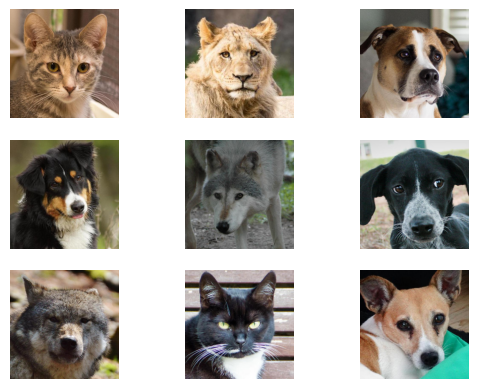

In [38]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')

plt.show()

In [39]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [40]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [56]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)

        self.output = nn.Linear(128, len(data_df['labels'].unique()))

    def forward(self, x):
        x = self.conv1(x) # -> (32, 128, 128)
        x = self.pooling(x) # -> (32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x) # -> (64, 64, 64)
        x = self.pooling(x) # -> (64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x) # -> (128, 32, 32)
        x = self.pooling(x) # -> (128, 16, 16)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)

        return x

In [57]:
model = Net().to(device)

In [58]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [62]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_acc_val = 0
    total_loss_train = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()

        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_val_plot.append(round(total_loss_val/1000, 4))

    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__(), 4))
    total_acc_val_plot.append(round(total_acc_val/val_dataset.__len__(), 4))

    print(f"""Epoch {epoch+1}/{EPOCHS}, Train Loss：{round(total_loss_train/1000, 4)}, Train Acc: {round(total_acc_train/train_dataset.__len__(), 4)}
            Validation Loss: {round(total_loss_val/1000, 4)}, Validation Acc: {round(total_acc_val/val_dataset.__len__(), 4)}""")

Epoch 1/10, Train Loss：0.3418, Train Acc: 0.7988
            Validation Loss: 0.0377, Validation Acc: 0.9161
Epoch 2/10, Train Loss：0.1493, Train Acc: 0.9229
            Validation Loss: 0.0275, Validation Acc: 0.9293
Epoch 3/10, Train Loss：0.0914, Train Acc: 0.9541
            Validation Loss: 0.0198, Validation Acc: 0.9517
Epoch 4/10, Train Loss：0.0662, Train Acc: 0.9681
            Validation Loss: 0.0175, Validation Acc: 0.9607
Epoch 5/10, Train Loss：0.0473, Train Acc: 0.9775
            Validation Loss: 0.0152, Validation Acc: 0.9645
Epoch 6/10, Train Loss：0.0345, Train Acc: 0.9823
            Validation Loss: 0.0166, Validation Acc: 0.9649
Epoch 7/10, Train Loss：0.0262, Train Acc: 0.9866
            Validation Loss: 0.0148, Validation Acc: 0.9698
Epoch 8/10, Train Loss：0.0175, Train Acc: 0.9919
            Validation Loss: 0.0194, Validation Acc: 0.9616
Epoch 9/10, Train Loss：0.0137, Train Acc: 0.993
            Validation Loss: 0.0156, Validation Acc: 0.9694
Epoch 10/10, Train L

In [63]:
with torch.no_grad():
    total_loss_test, total_acc_test = 0, 0
    for inputs, labels in test_loader:
        predictions = model(inputs)

        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()
    print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 95.9487 and Loss is 0.0233


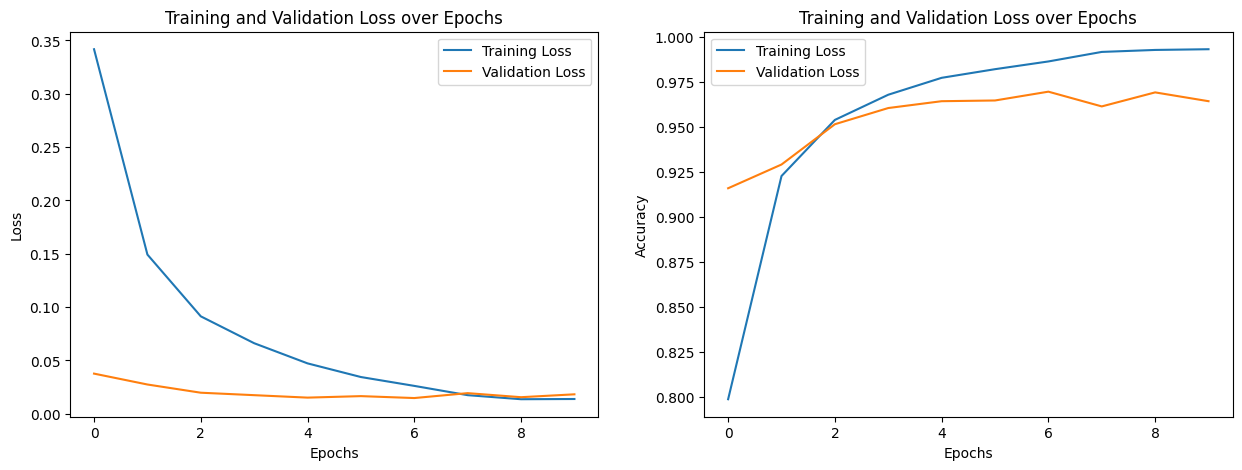

In [67]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

axs[0].plot(total_loss_train_plot, label = 'Training Loss')
axs[0].plot(total_loss_val_plot, label = 'Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Training Loss')
axs[1].plot(total_acc_val_plot, label = 'Validation Loss')
axs[1].set_title('Training and Validation Loss over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()